In [ ]:
! pip install torch torchvision pennylane matplotlib scikit-learn

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

# a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# --- Hyperparameters and Setup ---
n_qubits = 6         # Number of qubits in the VQC. 
q_depth = 2          # Number of layers in the VQC ansatz.
batch_size = 16      # Batch size for training.
epochs = 30          # Number of training epochs.
learning_rate = 1e-3 # Learning rate for the optimizer.
device = "cpu"

# Number of samples 
n_samples_train = 2000
n_samples_test = 1000

# --- Data Loading ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the full datasets
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# subsets with a smaller number of samples for faster training
train_indices = torch.randperm(len(full_train_dataset))[:n_samples_train]
test_indices = torch.randperm(len(full_test_dataset))[:n_samples_test]

train_dataset = Subset(full_train_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training data samples: {len(train_dataset)}")
print(f"Test data samples: {len(test_dataset)}")

Training data samples: 2000
Test data samples: 1000


In [ ]:
#  The quantum device
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """The Variational Quantum Circuit (VQC)"""
    # 1. Encoding classical features into quantum state
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # 2. Trainable variational layers (anstaz)
    for i in range(q_depth):
        # Parameterized rotations
        for y in range(n_qubits):
            qml.Rot(weights[i, y, 0], weights[i, y, 1], weights[i, y, 2], wires=y)

        # Entanglement layer (linear chain)
        for y in range(n_qubits - 1):
            qml.CNOT(wires=[y, y + 1])

    # 3. Expectation value of PauliZ for each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# For visualization
weight_shapes = {"weights": (q_depth, n_qubits, 3)}
q_layer_for_drawing = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

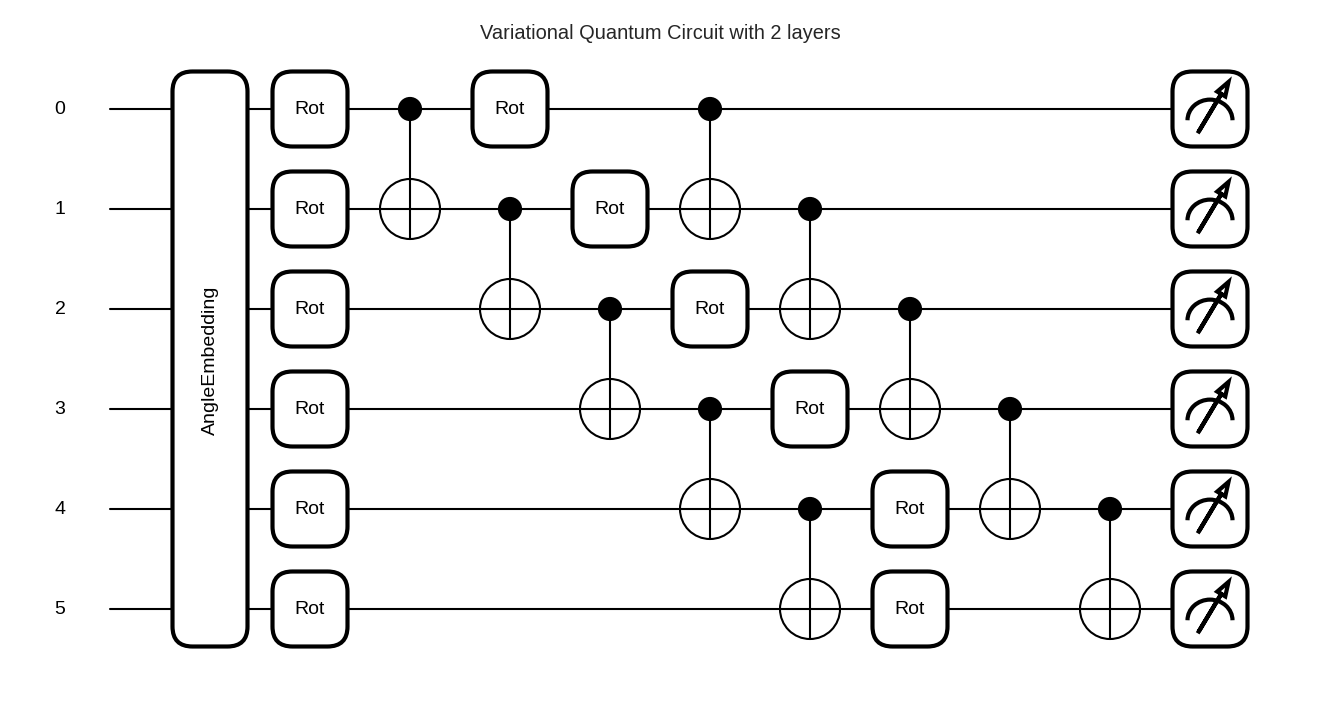

In [ ]:
# dummy inputs for drawing
dummy_inputs = torch.randn(n_qubits)
dummy_weights = torch.randn(q_depth, n_qubits, 3)

# The circuit using matplotlib
fig, ax = qml.draw_mpl(quantum_circuit)(dummy_inputs, dummy_weights)
fig.suptitle(f"Variational Quantum Circuit with {q_depth} layers", fontsize='x-large')
plt.show()

In [ ]:
class HybridQCNN(nn.Module):
    def __init__(self, q_layer):
        super(HybridQCNN, self).__init__()

        # Classical feature extractor
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Flattening and dimensionality reduction
        self.fc1 = nn.Linear(8 * 7 * 7, n_qubits)

        # Quantum layer
        self.q_layer = q_layer

        # Final classical classification layer
        self.fc2 = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.q_layer(x)
        x = self.fc2(x)
        return x

# Instantiate the model
weight_shapes = {"weights": (q_depth, n_qubits, 3)}
q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
model = HybridQCNN(q_layer).to(device)

# model summary
print("Hybrid QCNN Model Architecture for Multi-Class Classification:")
print(model)

Hybrid QCNN Model Architecture for Multi-Class Classification:
HybridQCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=392, out_features=6, bias=True)
  (q_layer): <Quantum Torch Layer: func=quantum_circuit>
  (fc2): Linear(in_features=6, out_features=10, bias=True)
)


In [82]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_targets

# --- Main Training Execution ---
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses = [], []
train_accs, test_accs = [], []

print("\nStarting training for all 10 digits...")
start_time = time.time()

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, _, _ = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%.. "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")


Starting training for all 10 digits...
Epoch 1/30.. Train Loss: 2.2453, Train Acc: 19.25%.. Test Loss: 2.0866, Test Acc: 38.40%
Epoch 2/30.. Train Loss: 1.9389, Train Acc: 55.50%.. Test Loss: 1.8098, Test Acc: 61.30%
Epoch 3/30.. Train Loss: 1.6795, Train Acc: 69.90%.. Test Loss: 1.5645, Test Acc: 71.50%
Epoch 4/30.. Train Loss: 1.4449, Train Acc: 78.45%.. Test Loss: 1.3433, Test Acc: 79.50%
Epoch 5/30.. Train Loss: 1.2425, Train Acc: 82.30%.. Test Loss: 1.1724, Test Acc: 82.10%
Epoch 6/30.. Train Loss: 1.0739, Train Acc: 83.65%.. Test Loss: 1.0309, Test Acc: 83.90%
Epoch 7/30.. Train Loss: 0.9271, Train Acc: 86.00%.. Test Loss: 0.9031, Test Acc: 85.30%
Epoch 8/30.. Train Loss: 0.8264, Train Acc: 87.00%.. Test Loss: 0.8254, Test Acc: 85.80%
Epoch 9/30.. Train Loss: 0.7333, Train Acc: 88.45%.. Test Loss: 0.7555, Test Acc: 87.30%
Epoch 10/30.. Train Loss: 0.6638, Train Acc: 89.60%.. Test Loss: 0.6991, Test Acc: 87.20%
Epoch 11/30.. Train Loss: 0.6026, Train Acc: 90.85%.. Test Loss: 0.65

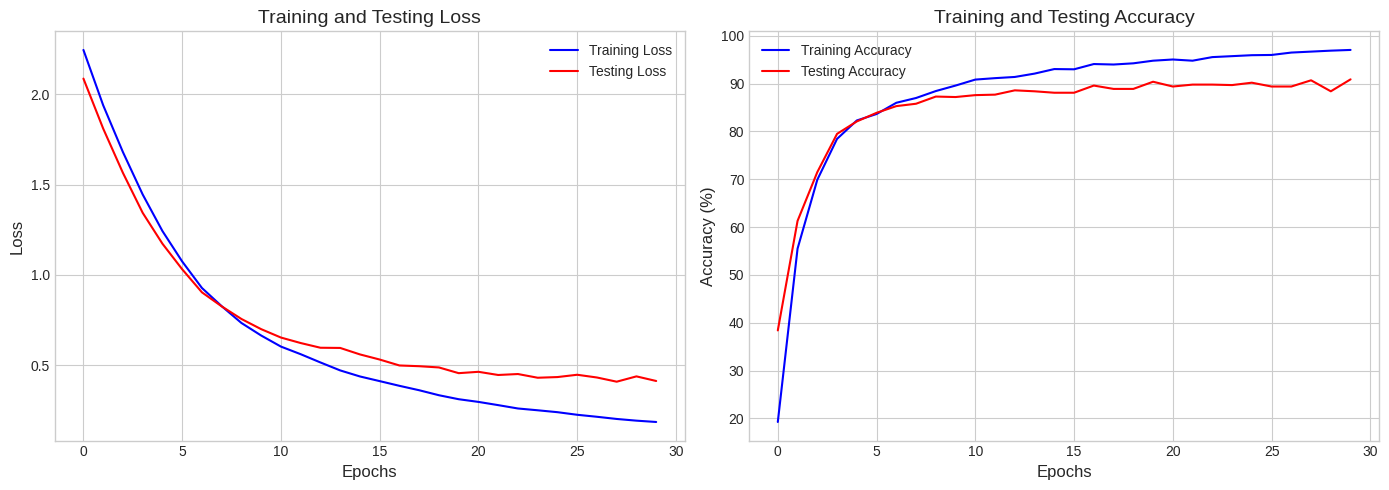

In [83]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting Loss
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(test_losses, label='Testing Loss', color='red')
ax1.set_title('Training and Testing Loss', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plotting Accuracy
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(test_accs, label='Testing Accuracy', color='red')
ax2.set_title('Training and Testing Accuracy', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [84]:
# Final evaluation on the test set
test_loss, test_acc, y_pred, y_true = test(model, test_loader, criterion, device)
print(f'\nFinal Test Accuracy on {n_samples_test} samples: {test_acc:.2f}%')



Final Test Accuracy on 1000 samples: 90.90%


              precision    recall  f1-score   support

           0     0.8957    0.9537    0.9238       108
           1     0.9558    0.9391    0.9474       115
           2     0.9266    0.9352    0.9309       108
           3     0.9574    0.8911    0.9231       101
           4     0.8587    0.8495    0.8541        93
           5     0.9130    0.9767    0.9438        86
           6     0.9551    0.9140    0.9341        93
           7     0.9670    0.9072    0.9362        97
           8     0.8300    0.8557    0.8426        97
           9     0.8381    0.8627    0.8502       102

    accuracy                         0.9090      1000
   macro avg     0.9097    0.9085    0.9086      1000
weighted avg     0.9104    0.9090    0.9092      1000



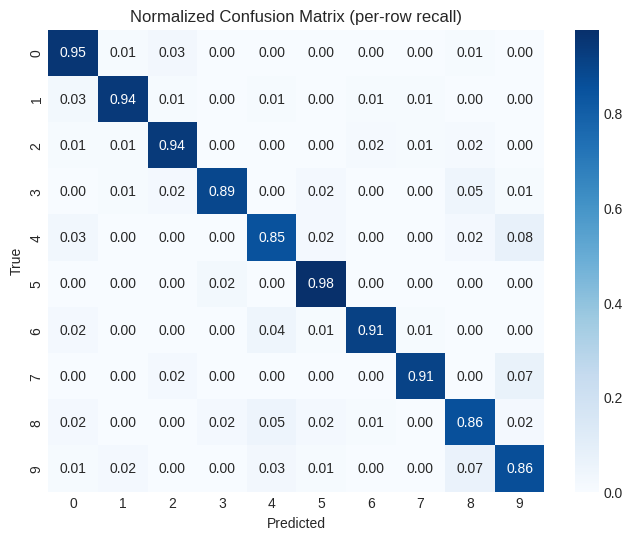

In [ ]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)         # raw counts
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]   # normalized per-row 
print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Normalized Confusion Matrix (per-row recall)")
plt.show()

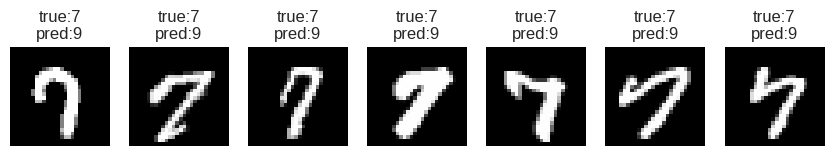

In [ ]:
#To see misclassified data
def show_misclassified(dataset, y_true, y_pred, true_label, pred_label, max_imgs=9):
    indices = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t==true_label and p==pred_label]
    if not indices:
        print("No misclassifications for that pair.")
        return
    n = min(len(indices), max_imgs)
    plt.figure(figsize=(n*1.5, 2))
    for i, idx in enumerate(indices[:n]):
        img, _ = dataset[idx]   # dataset returns (img, label) for torchvision MNIST
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(), cmap='gray'); plt.axis('off')
        plt.title(f"true:{true_label}\npred:{pred_label}")
    plt.show()

# For misclassifiying 7 as 9
show_misclassified(test_dataset, y_true, y_pred, 7, 9, max_imgs=9)
